In [1]:
import os
import os.path
import glob
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import matplotlib.cm as colormap
%matplotlib inline

import numpy as np
np.random.seed(1)

import random
from skimage import io
import cv2
from keras.preprocessing.image import img_to_array
from vis.utils import utils
from vis.visualization import visualize_cam,visualize_saliency

from keras import backend as K
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import RMSprop, SGD

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyImagesWidth"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False)

In [7]:
filename = 'virussign-resnet50features.npy'
if os.path.exists(filename):
    print("Loading ResNet50 extracted features from %s ..." %(filename))
    resnet50features = np.load(filename)
else:
    print("Extracting features from ResNet50 layers ...")
    resnet50features = base_model.predict(X)
    print("Saving ResNet50 extracted features into %s ..." %(filename))
    np.save(filename, resnet50features)

Extracting features from ResNet50 layers ...
Saving ResNet50 extracted features into virussign-resnet50features.npy ...


In [8]:
resnet50features.shape

(9339, 1, 1, 2048)

In [9]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [10]:
# Training top_model and saving min training loss weights
num_epochs=400
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='virussign-top-weights-min_loss-mlp-resnet50-Adam-400epochs.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = resnet50features[train_indices]
    Y_train = Y[train_indices]
    X_test = resnet50features[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    top_input = Input(shape=resnet50features.shape[1:])
    x = GlobalAveragePooling2D(name='avg_pool')(top_input)
    predict = Dense(num_classes, activation='softmax', name='predictions')(x)
    top_model = Model(input=top_input, output=predict)                            
    top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    h = top_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=X_train.shape[0], verbose=1, callbacks=[checkpointer])
    history.append(h)
    
    y_prob = top_model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("in...)`


Train on 8394 samples, validate on 945 samples
Epoch 1/400
8394/8394 [==============================] - 0s - loss: 4.8370 - acc: 0.0394 - val_loss: 3.9053 - val_acc: 0.0370
Epoch 2/400
8394/8394 [==============================] - 0s - loss: 3.9100 - acc: 0.0367 - val_loss: 3.2292 - val_acc: 0.2127
Epoch 3/400
8394/8394 [==============================] - 0s - loss: 3.2311 - acc: 0.2086 - val_loss: 2.7092 - val_acc: 0.2392
Epoch 4/400
8394/8394 [==============================] - 0s - loss: 2.7074 - acc: 0.2399 - val_loss: 2.3166 - val_acc: 0.2444
Epoch 5/400
8394/8394 [==============================] - 0s - loss: 2.3104 - acc: 0.2415 - val_loss: 2.0595 - val_acc: 0.4698
Epoch 6/400
8394/8394 [==============================] - 0s - loss: 2.0488 - acc: 0.4532 - val_loss: 1.9025 - val_acc: 0.4233
Epoch 7/400
8394/8394 [==============================] - 0s - loss: 1.8882 - acc: 0.4116 - val_loss: 1.8053 - val_acc: 0.3989
Epoch 8/400
8394/8394 [==============================] - 0s - loss: 1.7

8394/8394 [==============================] - 0s - loss: 0.2200 - acc: 0.9434 - val_loss: 0.2426 - val_acc: 0.9333
Epoch 66/400
8394/8394 [==============================] - 0s - loss: 0.2176 - acc: 0.9440 - val_loss: 0.2403 - val_acc: 0.9333
Epoch 67/400
8394/8394 [==============================] - 0s - loss: 0.2152 - acc: 0.9444 - val_loss: 0.2381 - val_acc: 0.9333
Epoch 68/400
8394/8394 [==============================] - 0s - loss: 0.2129 - acc: 0.9453 - val_loss: 0.2359 - val_acc: 0.9344
Epoch 69/400
8394/8394 [==============================] - 0s - loss: 0.2107 - acc: 0.9458 - val_loss: 0.2337 - val_acc: 0.9365
Epoch 70/400
8394/8394 [==============================] - 0s - loss: 0.2085 - acc: 0.9464 - val_loss: 0.2315 - val_acc: 0.9365
Epoch 71/400
8394/8394 [==============================] - 0s - loss: 0.2063 - acc: 0.9471 - val_loss: 0.2294 - val_acc: 0.9376
Epoch 72/400
8394/8394 [==============================] - 0s - loss: 0.2042 - acc: 0.9477 - val_loss: 0.2274 - val_acc: 0.93

8394/8394 [==============================] - 0s - loss: 0.1335 - acc: 0.9634 - val_loss: 0.1599 - val_acc: 0.9524
Epoch 130/400
8394/8394 [==============================] - 0s - loss: 0.1327 - acc: 0.9635 - val_loss: 0.1592 - val_acc: 0.9534
Epoch 131/400
8394/8394 [==============================] - 0s - loss: 0.1320 - acc: 0.9637 - val_loss: 0.1585 - val_acc: 0.9534
Epoch 132/400
8394/8394 [==============================] - 0s - loss: 0.1312 - acc: 0.9638 - val_loss: 0.1578 - val_acc: 0.9534
Epoch 133/400
8394/8394 [==============================] - 0s - loss: 0.1305 - acc: 0.9638 - val_loss: 0.1571 - val_acc: 0.9534
Epoch 134/400
8394/8394 [==============================] - 0s - loss: 0.1298 - acc: 0.9639 - val_loss: 0.1564 - val_acc: 0.9534
Epoch 135/400
8394/8394 [==============================] - 0s - loss: 0.1291 - acc: 0.9639 - val_loss: 0.1558 - val_acc: 0.9534
Epoch 136/400
8394/8394 [==============================] - 0s - loss: 0.1284 - acc: 0.9641 - val_loss: 0.1551 - val_ac

8394/8394 [==============================] - 0s - loss: 0.0988 - acc: 0.9743 - val_loss: 0.1272 - val_acc: 0.9587
Epoch 194/400
8394/8394 [==============================] - 0s - loss: 0.0984 - acc: 0.9744 - val_loss: 0.1268 - val_acc: 0.9598
Epoch 195/400
8394/8394 [==============================] - 0s - loss: 0.0980 - acc: 0.9745 - val_loss: 0.1265 - val_acc: 0.9598
Epoch 196/400
8394/8394 [==============================] - 0s - loss: 0.0976 - acc: 0.9747 - val_loss: 0.1261 - val_acc: 0.9598
Epoch 197/400
8394/8394 [==============================] - 0s - loss: 0.0973 - acc: 0.9747 - val_loss: 0.1257 - val_acc: 0.9598
Epoch 198/400
8394/8394 [==============================] - 0s - loss: 0.0969 - acc: 0.9747 - val_loss: 0.1254 - val_acc: 0.9598
Epoch 199/400
8394/8394 [==============================] - 0s - loss: 0.0965 - acc: 0.9747 - val_loss: 0.1250 - val_acc: 0.9598
Epoch 200/400
8394/8394 [==============================] - 0s - loss: 0.0961 - acc: 0.9749 - val_loss: 0.1247 - val_ac

8394/8394 [==============================] - 0s - loss: 0.0788 - acc: 0.9796 - val_loss: 0.1081 - val_acc: 0.9651
Epoch 258/400
8394/8394 [==============================] - 0s - loss: 0.0785 - acc: 0.9796 - val_loss: 0.1079 - val_acc: 0.9651
Epoch 259/400
8394/8394 [==============================] - 0s - loss: 0.0783 - acc: 0.9796 - val_loss: 0.1077 - val_acc: 0.9651
Epoch 260/400
8394/8394 [==============================] - 0s - loss: 0.0780 - acc: 0.9796 - val_loss: 0.1074 - val_acc: 0.9651
Epoch 261/400
8394/8394 [==============================] - 0s - loss: 0.0778 - acc: 0.9799 - val_loss: 0.1072 - val_acc: 0.9651
Epoch 262/400
8394/8394 [==============================] - 0s - loss: 0.0775 - acc: 0.9799 - val_loss: 0.1070 - val_acc: 0.9651
Epoch 263/400
8394/8394 [==============================] - 0s - loss: 0.0773 - acc: 0.9799 - val_loss: 0.1067 - val_acc: 0.9651
Epoch 264/400
8394/8394 [==============================] - 0s - loss: 0.0770 - acc: 0.9800 - val_loss: 0.1065 - val_ac

8394/8394 [==============================] - 0s - loss: 0.0650 - acc: 0.9817 - val_loss: 0.0951 - val_acc: 0.9651
Epoch 322/400
8394/8394 [==============================] - 0s - loss: 0.0649 - acc: 0.9817 - val_loss: 0.0950 - val_acc: 0.9651
Epoch 323/400
8394/8394 [==============================] - 0s - loss: 0.0647 - acc: 0.9818 - val_loss: 0.0948 - val_acc: 0.9651
Epoch 324/400
8394/8394 [==============================] - 0s - loss: 0.0645 - acc: 0.9818 - val_loss: 0.0946 - val_acc: 0.9651
Epoch 325/400
8394/8394 [==============================] - 0s - loss: 0.0643 - acc: 0.9818 - val_loss: 0.0944 - val_acc: 0.9651
Epoch 326/400
8394/8394 [==============================] - 0s - loss: 0.0641 - acc: 0.9819 - val_loss: 0.0943 - val_acc: 0.9651
Epoch 327/400
8394/8394 [==============================] - 0s - loss: 0.0640 - acc: 0.9819 - val_loss: 0.0941 - val_acc: 0.9651
Epoch 328/400
8394/8394 [==============================] - 0s - loss: 0.0638 - acc: 0.9819 - val_loss: 0.0939 - val_ac

8394/8394 [==============================] - 0s - loss: 0.0548 - acc: 0.9826 - val_loss: 0.0855 - val_acc: 0.9661
Epoch 386/400
8394/8394 [==============================] - 0s - loss: 0.0546 - acc: 0.9826 - val_loss: 0.0854 - val_acc: 0.9661
Epoch 387/400
8394/8394 [==============================] - 0s - loss: 0.0545 - acc: 0.9826 - val_loss: 0.0853 - val_acc: 0.9661
Epoch 388/400
8394/8394 [==============================] - 0s - loss: 0.0543 - acc: 0.9828 - val_loss: 0.0851 - val_acc: 0.9661
Epoch 389/400
8394/8394 [==============================] - 0s - loss: 0.0542 - acc: 0.9828 - val_loss: 0.0850 - val_acc: 0.9661
Epoch 390/400
8394/8394 [==============================] - 0s - loss: 0.0541 - acc: 0.9828 - val_loss: 0.0849 - val_acc: 0.9661
Epoch 391/400
8394/8394 [==============================] - 0s - loss: 0.0539 - acc: 0.9828 - val_loss: 0.0847 - val_acc: 0.9661
Epoch 392/400
8394/8394 [==============================] - 0s - loss: 0.0538 - acc: 0.9828 - val_loss: 0.0846 - val_ac

8397/8397 [==============================] - 0s - loss: 0.2622 - acc: 0.9397 - val_loss: 0.2647 - val_acc: 0.9352
Epoch 49/400
8397/8397 [==============================] - 0s - loss: 0.2581 - acc: 0.9403 - val_loss: 0.2611 - val_acc: 0.9384
Epoch 50/400
8397/8397 [==============================] - 0s - loss: 0.2542 - acc: 0.9409 - val_loss: 0.2577 - val_acc: 0.9374
Epoch 51/400
8397/8397 [==============================] - 0s - loss: 0.2506 - acc: 0.9411 - val_loss: 0.2544 - val_acc: 0.9363
Epoch 52/400
8397/8397 [==============================] - 0s - loss: 0.2472 - acc: 0.9415 - val_loss: 0.2513 - val_acc: 0.9363
Epoch 53/400
8397/8397 [==============================] - 0s - loss: 0.2440 - acc: 0.9418 - val_loss: 0.2483 - val_acc: 0.9374
Epoch 54/400
8397/8397 [==============================] - 0s - loss: 0.2409 - acc: 0.9425 - val_loss: 0.2453 - val_acc: 0.9374
Epoch 55/400
8397/8397 [==============================] - 0s - loss: 0.2379 - acc: 0.9433 - val_loss: 0.2424 - val_acc: 0.93

8397/8397 [==============================] - 0s - loss: 0.1507 - acc: 0.9578 - val_loss: 0.1633 - val_acc: 0.9544
Epoch 113/400
8397/8397 [==============================] - 0s - loss: 0.1498 - acc: 0.9580 - val_loss: 0.1625 - val_acc: 0.9544
Epoch 114/400
8397/8397 [==============================] - 0s - loss: 0.1490 - acc: 0.9582 - val_loss: 0.1618 - val_acc: 0.9544
Epoch 115/400
8397/8397 [==============================] - 0s - loss: 0.1481 - acc: 0.9588 - val_loss: 0.1610 - val_acc: 0.9554
Epoch 116/400
8397/8397 [==============================] - 0s - loss: 0.1473 - acc: 0.9590 - val_loss: 0.1603 - val_acc: 0.9554
Epoch 117/400
8397/8397 [==============================] - 0s - loss: 0.1465 - acc: 0.9593 - val_loss: 0.1596 - val_acc: 0.9554
Epoch 118/400
8397/8397 [==============================] - 0s - loss: 0.1457 - acc: 0.9594 - val_loss: 0.1589 - val_acc: 0.9554
Epoch 119/400
8397/8397 [==============================] - 0s - loss: 0.1449 - acc: 0.9594 - val_loss: 0.1582 - val_ac

8397/8397 [==============================] - 0s - loss: 0.1104 - acc: 0.9668 - val_loss: 0.1280 - val_acc: 0.9575
Epoch 177/400
8397/8397 [==============================] - 0s - loss: 0.1099 - acc: 0.9670 - val_loss: 0.1276 - val_acc: 0.9575
Epoch 178/400
8397/8397 [==============================] - 0s - loss: 0.1094 - acc: 0.9670 - val_loss: 0.1272 - val_acc: 0.9575
Epoch 179/400
8397/8397 [==============================] - 0s - loss: 0.1090 - acc: 0.9671 - val_loss: 0.1268 - val_acc: 0.9575
Epoch 180/400
8397/8397 [==============================] - 0s - loss: 0.1085 - acc: 0.9671 - val_loss: 0.1264 - val_acc: 0.9575
Epoch 181/400
8397/8397 [==============================] - 0s - loss: 0.1081 - acc: 0.9671 - val_loss: 0.1260 - val_acc: 0.9575
Epoch 182/400
8397/8397 [==============================] - 0s - loss: 0.1076 - acc: 0.9673 - val_loss: 0.1256 - val_acc: 0.9575
Epoch 183/400
8397/8397 [==============================] - 0s - loss: 0.1072 - acc: 0.9673 - val_loss: 0.1252 - val_ac

8397/8397 [==============================] - 0s - loss: 0.0865 - acc: 0.9725 - val_loss: 0.1075 - val_acc: 0.9575
Epoch 241/400
8397/8397 [==============================] - 0s - loss: 0.0862 - acc: 0.9725 - val_loss: 0.1072 - val_acc: 0.9575
Epoch 242/400
8397/8397 [==============================] - 0s - loss: 0.0859 - acc: 0.9725 - val_loss: 0.1070 - val_acc: 0.9586
Epoch 243/400
8397/8397 [==============================] - 0s - loss: 0.0856 - acc: 0.9725 - val_loss: 0.1067 - val_acc: 0.9586
Epoch 244/400
8397/8397 [==============================] - 0s - loss: 0.0854 - acc: 0.9725 - val_loss: 0.1065 - val_acc: 0.9586
Epoch 245/400
8397/8397 [==============================] - 0s - loss: 0.0851 - acc: 0.9726 - val_loss: 0.1062 - val_acc: 0.9586
Epoch 246/400
8397/8397 [==============================] - 0s - loss: 0.0848 - acc: 0.9726 - val_loss: 0.1060 - val_acc: 0.9586
Epoch 247/400
8397/8397 [==============================] - 0s - loss: 0.0845 - acc: 0.9727 - val_loss: 0.1058 - val_ac

8397/8397 [==============================] - 0s - loss: 0.0704 - acc: 0.9768 - val_loss: 0.0939 - val_acc: 0.9628
Epoch 305/400
8397/8397 [==============================] - 0s - loss: 0.0702 - acc: 0.9768 - val_loss: 0.0937 - val_acc: 0.9628
Epoch 306/400
8397/8397 [==============================] - 0s - loss: 0.0700 - acc: 0.9771 - val_loss: 0.0935 - val_acc: 0.9628
Epoch 307/400
8397/8397 [==============================] - 0s - loss: 0.0697 - acc: 0.9771 - val_loss: 0.0934 - val_acc: 0.9628
Epoch 308/400
8397/8397 [==============================] - 0s - loss: 0.0695 - acc: 0.9771 - val_loss: 0.0932 - val_acc: 0.9628
Epoch 309/400
8397/8397 [==============================] - 0s - loss: 0.0693 - acc: 0.9771 - val_loss: 0.0930 - val_acc: 0.9628
Epoch 310/400
8397/8397 [==============================] - 0s - loss: 0.0691 - acc: 0.9771 - val_loss: 0.0928 - val_acc: 0.9628
Epoch 311/400
8397/8397 [==============================] - 0s - loss: 0.0689 - acc: 0.9771 - val_loss: 0.0927 - val_ac

8397/8397 [==============================] - 0s - loss: 0.0586 - acc: 0.9808 - val_loss: 0.0842 - val_acc: 0.9682
Epoch 369/400
8397/8397 [==============================] - 0s - loss: 0.0584 - acc: 0.9811 - val_loss: 0.0840 - val_acc: 0.9682
Epoch 370/400
8397/8397 [==============================] - 0s - loss: 0.0583 - acc: 0.9812 - val_loss: 0.0839 - val_acc: 0.9682
Epoch 371/400
8397/8397 [==============================] - 0s - loss: 0.0581 - acc: 0.9815 - val_loss: 0.0838 - val_acc: 0.9682
Epoch 372/400
8397/8397 [==============================] - 0s - loss: 0.0580 - acc: 0.9818 - val_loss: 0.0837 - val_acc: 0.9682
Epoch 373/400
8397/8397 [==============================] - 0s - loss: 0.0578 - acc: 0.9819 - val_loss: 0.0835 - val_acc: 0.9682
Epoch 374/400
8397/8397 [==============================] - 0s - loss: 0.0577 - acc: 0.9821 - val_loss: 0.0834 - val_acc: 0.9682
Epoch 375/400
8397/8397 [==============================] - 0s - loss: 0.0575 - acc: 0.9821 - val_loss: 0.0833 - val_ac

8401/8401 [==============================] - 0s - loss: 0.4402 - acc: 0.8872 - val_loss: 0.4258 - val_acc: 0.8806
Epoch 32/400
8401/8401 [==============================] - 0s - loss: 0.4180 - acc: 0.8925 - val_loss: 0.4075 - val_acc: 0.8945
Epoch 33/400
8401/8401 [==============================] - 0s - loss: 0.4004 - acc: 0.9022 - val_loss: 0.3936 - val_acc: 0.9062
Epoch 34/400
8401/8401 [==============================] - 0s - loss: 0.3870 - acc: 0.9114 - val_loss: 0.3831 - val_acc: 0.9168
Epoch 35/400
8401/8401 [==============================] - 0s - loss: 0.3769 - acc: 0.9170 - val_loss: 0.3747 - val_acc: 0.9222
Epoch 36/400
8401/8401 [==============================] - 0s - loss: 0.3689 - acc: 0.9222 - val_loss: 0.3670 - val_acc: 0.9254
Epoch 37/400
8401/8401 [==============================] - 0s - loss: 0.3615 - acc: 0.9241 - val_loss: 0.3590 - val_acc: 0.9254
Epoch 38/400
8401/8401 [==============================] - 0s - loss: 0.3539 - acc: 0.9256 - val_loss: 0.3504 - val_acc: 0.92

8401/8401 [==============================] - 0s - loss: 0.1738 - acc: 0.9495 - val_loss: 0.1804 - val_acc: 0.9488
Epoch 96/400
8401/8401 [==============================] - 0s - loss: 0.1726 - acc: 0.9500 - val_loss: 0.1793 - val_acc: 0.9499
Epoch 97/400
8401/8401 [==============================] - 0s - loss: 0.1713 - acc: 0.9504 - val_loss: 0.1782 - val_acc: 0.9499
Epoch 98/400
8401/8401 [==============================] - 0s - loss: 0.1701 - acc: 0.9511 - val_loss: 0.1770 - val_acc: 0.9510
Epoch 99/400
8401/8401 [==============================] - 0s - loss: 0.1689 - acc: 0.9513 - val_loss: 0.1760 - val_acc: 0.9510
Epoch 100/400
8401/8401 [==============================] - 0s - loss: 0.1678 - acc: 0.9514 - val_loss: 0.1749 - val_acc: 0.9510
Epoch 101/400
8401/8401 [==============================] - 0s - loss: 0.1666 - acc: 0.9516 - val_loss: 0.1738 - val_acc: 0.9520
Epoch 102/400
8401/8401 [==============================] - 0s - loss: 0.1655 - acc: 0.9517 - val_loss: 0.1727 - val_acc: 0

8401/8401 [==============================] - 0s - loss: 0.1206 - acc: 0.9686 - val_loss: 0.1301 - val_acc: 0.9659
Epoch 160/400
8401/8401 [==============================] - 0s - loss: 0.1200 - acc: 0.9688 - val_loss: 0.1296 - val_acc: 0.9659
Epoch 161/400
8401/8401 [==============================] - 0s - loss: 0.1195 - acc: 0.9693 - val_loss: 0.1291 - val_acc: 0.9659
Epoch 162/400
8401/8401 [==============================] - 0s - loss: 0.1190 - acc: 0.9698 - val_loss: 0.1286 - val_acc: 0.9659
Epoch 163/400
8401/8401 [==============================] - 0s - loss: 0.1184 - acc: 0.9698 - val_loss: 0.1281 - val_acc: 0.9659
Epoch 164/400
8401/8401 [==============================] - 0s - loss: 0.1179 - acc: 0.9700 - val_loss: 0.1276 - val_acc: 0.9659
Epoch 165/400
8401/8401 [==============================] - 0s - loss: 0.1174 - acc: 0.9702 - val_loss: 0.1271 - val_acc: 0.9659
Epoch 166/400
8401/8401 [==============================] - 0s - loss: 0.1168 - acc: 0.9702 - val_loss: 0.1266 - val_ac

8401/8401 [==============================] - 0s - loss: 0.0939 - acc: 0.9748 - val_loss: 0.1059 - val_acc: 0.9680
Epoch 224/400
8401/8401 [==============================] - 0s - loss: 0.0936 - acc: 0.9748 - val_loss: 0.1056 - val_acc: 0.9680
Epoch 225/400
8401/8401 [==============================] - 0s - loss: 0.0932 - acc: 0.9749 - val_loss: 0.1054 - val_acc: 0.9680
Epoch 226/400
8401/8401 [==============================] - 0s - loss: 0.0929 - acc: 0.9749 - val_loss: 0.1051 - val_acc: 0.9680
Epoch 227/400
8401/8401 [==============================] - 0s - loss: 0.0926 - acc: 0.9751 - val_loss: 0.1048 - val_acc: 0.9680
Epoch 228/400
8401/8401 [==============================] - 0s - loss: 0.0923 - acc: 0.9751 - val_loss: 0.1045 - val_acc: 0.9680
Epoch 229/400
8401/8401 [==============================] - 0s - loss: 0.0920 - acc: 0.9751 - val_loss: 0.1043 - val_acc: 0.9680
Epoch 230/400
8401/8401 [==============================] - 0s - loss: 0.0917 - acc: 0.9751 - val_loss: 0.1040 - val_ac

8401/8401 [==============================] - 0s - loss: 0.0772 - acc: 0.9774 - val_loss: 0.0914 - val_acc: 0.9680
Epoch 288/400
8401/8401 [==============================] - 0s - loss: 0.0770 - acc: 0.9774 - val_loss: 0.0912 - val_acc: 0.9680
Epoch 289/400
8401/8401 [==============================] - 0s - loss: 0.0767 - acc: 0.9774 - val_loss: 0.0911 - val_acc: 0.9680
Epoch 290/400
8401/8401 [==============================] - 0s - loss: 0.0765 - acc: 0.9774 - val_loss: 0.0909 - val_acc: 0.9691
Epoch 291/400
8401/8401 [==============================] - 0s - loss: 0.0763 - acc: 0.9775 - val_loss: 0.0907 - val_acc: 0.9691
Epoch 292/400
8401/8401 [==============================] - 0s - loss: 0.0761 - acc: 0.9779 - val_loss: 0.0905 - val_acc: 0.9691
Epoch 293/400
8401/8401 [==============================] - 0s - loss: 0.0759 - acc: 0.9779 - val_loss: 0.0903 - val_acc: 0.9691
Epoch 294/400
8401/8401 [==============================] - 0s - loss: 0.0757 - acc: 0.9779 - val_loss: 0.0902 - val_ac

8401/8401 [==============================] - 0s - loss: 0.0653 - acc: 0.9804 - val_loss: 0.0813 - val_acc: 0.9701
Epoch 352/400
8401/8401 [==============================] - 0s - loss: 0.0651 - acc: 0.9804 - val_loss: 0.0812 - val_acc: 0.9691
Epoch 353/400
8401/8401 [==============================] - 0s - loss: 0.0649 - acc: 0.9804 - val_loss: 0.0811 - val_acc: 0.9691
Epoch 354/400
8401/8401 [==============================] - 0s - loss: 0.0648 - acc: 0.9804 - val_loss: 0.0809 - val_acc: 0.9691
Epoch 355/400
8401/8401 [==============================] - 0s - loss: 0.0646 - acc: 0.9804 - val_loss: 0.0808 - val_acc: 0.9691
Epoch 356/400
8401/8401 [==============================] - 0s - loss: 0.0645 - acc: 0.9804 - val_loss: 0.0807 - val_acc: 0.9691
Epoch 357/400
8401/8401 [==============================] - 0s - loss: 0.0643 - acc: 0.9804 - val_loss: 0.0805 - val_acc: 0.9691
Epoch 358/400
8401/8401 [==============================] - 0s - loss: 0.0642 - acc: 0.9805 - val_loss: 0.0804 - val_ac

8403/8403 [==============================] - 0s - loss: 0.8222 - acc: 0.8136 - val_loss: 0.7740 - val_acc: 0.8248
Epoch 15/400
8403/8403 [==============================] - 0s - loss: 0.7678 - acc: 0.8292 - val_loss: 0.7274 - val_acc: 0.8387
Epoch 16/400
8403/8403 [==============================] - 0s - loss: 0.7204 - acc: 0.8395 - val_loss: 0.6834 - val_acc: 0.8590
Epoch 17/400
8403/8403 [==============================] - 0s - loss: 0.6759 - acc: 0.8611 - val_loss: 0.6405 - val_acc: 0.8729
Epoch 18/400
8403/8403 [==============================] - 0s - loss: 0.6328 - acc: 0.8800 - val_loss: 0.5990 - val_acc: 0.8846
Epoch 19/400
8403/8403 [==============================] - 0s - loss: 0.5914 - acc: 0.8892 - val_loss: 0.5610 - val_acc: 0.8889
Epoch 20/400
8403/8403 [==============================] - 0s - loss: 0.5536 - acc: 0.8947 - val_loss: 0.5282 - val_acc: 0.8900
Epoch 21/400
8403/8403 [==============================] - 0s - loss: 0.5209 - acc: 0.8967 - val_loss: 0.4999 - val_acc: 0.89

8403/8403 [==============================] - 0s - loss: 0.1698 - acc: 0.9522 - val_loss: 0.1748 - val_acc: 0.9466
Epoch 79/400
8403/8403 [==============================] - 0s - loss: 0.1683 - acc: 0.9526 - val_loss: 0.1732 - val_acc: 0.9466
Epoch 80/400
8403/8403 [==============================] - 0s - loss: 0.1667 - acc: 0.9526 - val_loss: 0.1717 - val_acc: 0.9476
Epoch 81/400
8403/8403 [==============================] - 0s - loss: 0.1653 - acc: 0.9535 - val_loss: 0.1702 - val_acc: 0.9487
Epoch 82/400
8403/8403 [==============================] - 0s - loss: 0.1638 - acc: 0.9539 - val_loss: 0.1687 - val_acc: 0.9498
Epoch 83/400
8403/8403 [==============================] - 0s - loss: 0.1624 - acc: 0.9544 - val_loss: 0.1673 - val_acc: 0.9519
Epoch 84/400
8403/8403 [==============================] - 0s - loss: 0.1610 - acc: 0.9549 - val_loss: 0.1659 - val_acc: 0.9519
Epoch 85/400
8403/8403 [==============================] - 0s - loss: 0.1596 - acc: 0.9550 - val_loss: 0.1645 - val_acc: 0.95

8403/8403 [==============================] - 0s - loss: 0.1089 - acc: 0.9689 - val_loss: 0.1153 - val_acc: 0.9658
Epoch 143/400
8403/8403 [==============================] - 0s - loss: 0.1084 - acc: 0.9689 - val_loss: 0.1147 - val_acc: 0.9658
Epoch 144/400
8403/8403 [==============================] - 0s - loss: 0.1078 - acc: 0.9689 - val_loss: 0.1142 - val_acc: 0.9658
Epoch 145/400
8403/8403 [==============================] - 0s - loss: 0.1072 - acc: 0.9693 - val_loss: 0.1137 - val_acc: 0.9658
Epoch 146/400
8403/8403 [==============================] - 0s - loss: 0.1066 - acc: 0.9699 - val_loss: 0.1131 - val_acc: 0.9669
Epoch 147/400
8403/8403 [==============================] - 0s - loss: 0.1061 - acc: 0.9701 - val_loss: 0.1126 - val_acc: 0.9669
Epoch 148/400
8403/8403 [==============================] - 0s - loss: 0.1055 - acc: 0.9702 - val_loss: 0.1121 - val_acc: 0.9669
Epoch 149/400
8403/8403 [==============================] - 0s - loss: 0.1050 - acc: 0.9702 - val_loss: 0.1116 - val_ac

8403/8403 [==============================] - 0s - loss: 0.0810 - acc: 0.9782 - val_loss: 0.0900 - val_acc: 0.9722
Epoch 207/400
8403/8403 [==============================] - 0s - loss: 0.0807 - acc: 0.9786 - val_loss: 0.0897 - val_acc: 0.9722
Epoch 208/400
8403/8403 [==============================] - 0s - loss: 0.0804 - acc: 0.9787 - val_loss: 0.0895 - val_acc: 0.9722
Epoch 209/400
8403/8403 [==============================] - 0s - loss: 0.0801 - acc: 0.9787 - val_loss: 0.0892 - val_acc: 0.9722
Epoch 210/400
8403/8403 [==============================] - 0s - loss: 0.0797 - acc: 0.9787 - val_loss: 0.0889 - val_acc: 0.9722
Epoch 211/400
8403/8403 [==============================] - 0s - loss: 0.0794 - acc: 0.9788 - val_loss: 0.0886 - val_acc: 0.9722
Epoch 212/400
8403/8403 [==============================] - 0s - loss: 0.0791 - acc: 0.9788 - val_loss: 0.0884 - val_acc: 0.9722
Epoch 213/400
8403/8403 [==============================] - 0s - loss: 0.0788 - acc: 0.9788 - val_loss: 0.0881 - val_ac

8403/8403 [==============================] - 0s - loss: 0.0641 - acc: 0.9816 - val_loss: 0.0759 - val_acc: 0.9744
Epoch 271/400
8403/8403 [==============================] - 0s - loss: 0.0639 - acc: 0.9816 - val_loss: 0.0757 - val_acc: 0.9744
Epoch 272/400
8403/8403 [==============================] - 0s - loss: 0.0637 - acc: 0.9816 - val_loss: 0.0755 - val_acc: 0.9744
Epoch 273/400
8403/8403 [==============================] - 0s - loss: 0.0635 - acc: 0.9816 - val_loss: 0.0753 - val_acc: 0.9744
Epoch 274/400
8403/8403 [==============================] - 0s - loss: 0.0633 - acc: 0.9816 - val_loss: 0.0752 - val_acc: 0.9744
Epoch 275/400
8403/8403 [==============================] - 0s - loss: 0.0631 - acc: 0.9816 - val_loss: 0.0750 - val_acc: 0.9744
Epoch 276/400
8403/8403 [==============================] - 0s - loss: 0.0629 - acc: 0.9816 - val_loss: 0.0748 - val_acc: 0.9744
Epoch 277/400
8403/8403 [==============================] - 0s - loss: 0.0627 - acc: 0.9816 - val_loss: 0.0747 - val_ac

8403/8403 [==============================] - 0s - loss: 0.0524 - acc: 0.9833 - val_loss: 0.0667 - val_acc: 0.9733
Epoch 335/400
8403/8403 [==============================] - 0s - loss: 0.0523 - acc: 0.9833 - val_loss: 0.0666 - val_acc: 0.9733
Epoch 336/400
8403/8403 [==============================] - 0s - loss: 0.0521 - acc: 0.9835 - val_loss: 0.0665 - val_acc: 0.9733
Epoch 337/400
8403/8403 [==============================] - 0s - loss: 0.0520 - acc: 0.9836 - val_loss: 0.0664 - val_acc: 0.9733
Epoch 338/400
8403/8403 [==============================] - 0s - loss: 0.0518 - acc: 0.9836 - val_loss: 0.0663 - val_acc: 0.9733
Epoch 339/400
8403/8403 [==============================] - 0s - loss: 0.0516 - acc: 0.9836 - val_loss: 0.0662 - val_acc: 0.9733
Epoch 340/400
8403/8403 [==============================] - 0s - loss: 0.0515 - acc: 0.9836 - val_loss: 0.0661 - val_acc: 0.9733
Epoch 341/400
8403/8403 [==============================] - 0s - loss: 0.0513 - acc: 0.9836 - val_loss: 0.0659 - val_ac

8403/8403 [==============================] - 0s - loss: 0.0437 - acc: 0.9956 - val_loss: 0.0604 - val_acc: 0.9850
Epoch 399/400
8403/8403 [==============================] - 0s - loss: 0.0436 - acc: 0.9957 - val_loss: 0.0604 - val_acc: 0.9850
Epoch 400/400
8403/8403 [==============================] - 0s - loss: 0.0435 - acc: 0.9957 - val_loss: 0.0603 - val_acc: 0.9850
[3] Test acurracy: 0.9850
Train on 8404 samples, validate on 935 samples
Epoch 1/400
8404/8404 [==============================] - 0s - loss: 4.2631 - acc: 0.0339 - val_loss: 3.5389 - val_acc: 0.0898
Epoch 2/400
8404/8404 [==============================] - 0s - loss: 3.5465 - acc: 0.1058 - val_loss: 2.9197 - val_acc: 0.3283
Epoch 3/400
8404/8404 [==============================] - 0s - loss: 2.9243 - acc: 0.3259 - val_loss: 2.5663 - val_acc: 0.3380
Epoch 4/400
8404/8404 [==============================] - 0s - loss: 2.5698 - acc: 0.3341 - val_loss: 2.2918 - val_acc: 0.3444
Epoch 5/400
8404/8404 [==============================

8404/8404 [==============================] - 0s - loss: 0.2105 - acc: 0.9453 - val_loss: 0.2074 - val_acc: 0.9390
Epoch 63/400
8404/8404 [==============================] - 0s - loss: 0.2080 - acc: 0.9460 - val_loss: 0.2051 - val_acc: 0.9401
Epoch 64/400
8404/8404 [==============================] - 0s - loss: 0.2055 - acc: 0.9469 - val_loss: 0.2027 - val_acc: 0.9412
Epoch 65/400
8404/8404 [==============================] - 0s - loss: 0.2031 - acc: 0.9475 - val_loss: 0.2005 - val_acc: 0.9422
Epoch 66/400
8404/8404 [==============================] - 0s - loss: 0.2007 - acc: 0.9482 - val_loss: 0.1983 - val_acc: 0.9444
Epoch 67/400
8404/8404 [==============================] - 0s - loss: 0.1984 - acc: 0.9491 - val_loss: 0.1962 - val_acc: 0.9444
Epoch 68/400
8404/8404 [==============================] - 0s - loss: 0.1962 - acc: 0.9499 - val_loss: 0.1942 - val_acc: 0.9433
Epoch 69/400
8404/8404 [==============================] - 0s - loss: 0.1941 - acc: 0.9504 - val_loss: 0.1923 - val_acc: 0.94

8404/8404 [==============================] - 0s - loss: 0.1263 - acc: 0.9639 - val_loss: 0.1320 - val_acc: 0.9551
Epoch 127/400
8404/8404 [==============================] - 0s - loss: 0.1256 - acc: 0.9641 - val_loss: 0.1314 - val_acc: 0.9551
Epoch 128/400
8404/8404 [==============================] - 0s - loss: 0.1248 - acc: 0.9647 - val_loss: 0.1308 - val_acc: 0.9551
Epoch 129/400
8404/8404 [==============================] - 0s - loss: 0.1241 - acc: 0.9651 - val_loss: 0.1302 - val_acc: 0.9551
Epoch 130/400
8404/8404 [==============================] - 0s - loss: 0.1234 - acc: 0.9651 - val_loss: 0.1296 - val_acc: 0.9561
Epoch 131/400
8404/8404 [==============================] - 0s - loss: 0.1227 - acc: 0.9654 - val_loss: 0.1290 - val_acc: 0.9561
Epoch 132/400
8404/8404 [==============================] - 0s - loss: 0.1221 - acc: 0.9654 - val_loss: 0.1284 - val_acc: 0.9561
Epoch 133/400
8404/8404 [==============================] - 0s - loss: 0.1214 - acc: 0.9654 - val_loss: 0.1279 - val_ac

8404/8404 [==============================] - 0s - loss: 0.0927 - acc: 0.9738 - val_loss: 0.1041 - val_acc: 0.9594
Epoch 191/400
8404/8404 [==============================] - 0s - loss: 0.0923 - acc: 0.9738 - val_loss: 0.1038 - val_acc: 0.9594
Epoch 192/400
8404/8404 [==============================] - 0s - loss: 0.0920 - acc: 0.9739 - val_loss: 0.1035 - val_acc: 0.9594
Epoch 193/400
8404/8404 [==============================] - 0s - loss: 0.0916 - acc: 0.9739 - val_loss: 0.1032 - val_acc: 0.9594
Epoch 194/400
8404/8404 [==============================] - 0s - loss: 0.0912 - acc: 0.9742 - val_loss: 0.1029 - val_acc: 0.9594
Epoch 195/400
8404/8404 [==============================] - 0s - loss: 0.0908 - acc: 0.9742 - val_loss: 0.1026 - val_acc: 0.9594
Epoch 196/400
8404/8404 [==============================] - 0s - loss: 0.0905 - acc: 0.9742 - val_loss: 0.1023 - val_acc: 0.9594
Epoch 197/400
8404/8404 [==============================] - 0s - loss: 0.0901 - acc: 0.9743 - val_loss: 0.1020 - val_ac

8404/8404 [==============================] - 0s - loss: 0.0730 - acc: 0.9782 - val_loss: 0.0886 - val_acc: 0.9658
Epoch 255/400
8404/8404 [==============================] - 0s - loss: 0.0728 - acc: 0.9782 - val_loss: 0.0884 - val_acc: 0.9658
Epoch 256/400
8404/8404 [==============================] - 0s - loss: 0.0725 - acc: 0.9782 - val_loss: 0.0882 - val_acc: 0.9658
Epoch 257/400
8404/8404 [==============================] - 0s - loss: 0.0723 - acc: 0.9783 - val_loss: 0.0880 - val_acc: 0.9658
Epoch 258/400
8404/8404 [==============================] - 0s - loss: 0.0720 - acc: 0.9783 - val_loss: 0.0879 - val_acc: 0.9658
Epoch 259/400
8404/8404 [==============================] - 0s - loss: 0.0718 - acc: 0.9783 - val_loss: 0.0877 - val_acc: 0.9658
Epoch 260/400
8404/8404 [==============================] - 0s - loss: 0.0715 - acc: 0.9785 - val_loss: 0.0875 - val_acc: 0.9658
Epoch 261/400
8404/8404 [==============================] - 0s - loss: 0.0713 - acc: 0.9785 - val_loss: 0.0873 - val_ac

8404/8404 [==============================] - 0s - loss: 0.0594 - acc: 0.9806 - val_loss: 0.0785 - val_acc: 0.9679
Epoch 319/400
8404/8404 [==============================] - 0s - loss: 0.0592 - acc: 0.9806 - val_loss: 0.0783 - val_acc: 0.9679
Epoch 320/400
8404/8404 [==============================] - 0s - loss: 0.0591 - acc: 0.9806 - val_loss: 0.0782 - val_acc: 0.9679
Epoch 321/400
8404/8404 [==============================] - 0s - loss: 0.0589 - acc: 0.9806 - val_loss: 0.0781 - val_acc: 0.9679
Epoch 322/400
8404/8404 [==============================] - 0s - loss: 0.0587 - acc: 0.9806 - val_loss: 0.0779 - val_acc: 0.9679
Epoch 323/400
8404/8404 [==============================] - 0s - loss: 0.0585 - acc: 0.9807 - val_loss: 0.0778 - val_acc: 0.9679
Epoch 324/400
8404/8404 [==============================] - 0s - loss: 0.0584 - acc: 0.9807 - val_loss: 0.0777 - val_acc: 0.9679
Epoch 325/400
8404/8404 [==============================] - 0s - loss: 0.0582 - acc: 0.9807 - val_loss: 0.0776 - val_ac

8404/8404 [==============================] - 0s - loss: 0.0493 - acc: 0.9833 - val_loss: 0.0713 - val_acc: 0.9701
Epoch 383/400
8404/8404 [==============================] - 0s - loss: 0.0492 - acc: 0.9833 - val_loss: 0.0712 - val_acc: 0.9701
Epoch 384/400
8404/8404 [==============================] - 0s - loss: 0.0490 - acc: 0.9833 - val_loss: 0.0711 - val_acc: 0.9701
Epoch 385/400
8404/8404 [==============================] - 0s - loss: 0.0489 - acc: 0.9833 - val_loss: 0.0710 - val_acc: 0.9701
Epoch 386/400
8404/8404 [==============================] - 0s - loss: 0.0488 - acc: 0.9833 - val_loss: 0.0709 - val_acc: 0.9701
Epoch 387/400
8404/8404 [==============================] - 0s - loss: 0.0486 - acc: 0.9833 - val_loss: 0.0708 - val_acc: 0.9701
Epoch 388/400
8404/8404 [==============================] - 0s - loss: 0.0485 - acc: 0.9835 - val_loss: 0.0707 - val_acc: 0.9701
Epoch 389/400
8404/8404 [==============================] - 0s - loss: 0.0484 - acc: 0.9835 - val_loss: 0.0706 - val_ac

8404/8404 [==============================] - 0s - loss: 0.3002 - acc: 0.9386 - val_loss: 0.3199 - val_acc: 0.9305
Epoch 46/400
8404/8404 [==============================] - 0s - loss: 0.2936 - acc: 0.9396 - val_loss: 0.3142 - val_acc: 0.9283
Epoch 47/400
8404/8404 [==============================] - 0s - loss: 0.2875 - acc: 0.9390 - val_loss: 0.3089 - val_acc: 0.9283
Epoch 48/400
8404/8404 [==============================] - 0s - loss: 0.2819 - acc: 0.9398 - val_loss: 0.3041 - val_acc: 0.9316
Epoch 49/400
8404/8404 [==============================] - 0s - loss: 0.2767 - acc: 0.9400 - val_loss: 0.2996 - val_acc: 0.9305
Epoch 50/400
8404/8404 [==============================] - 0s - loss: 0.2719 - acc: 0.9406 - val_loss: 0.2955 - val_acc: 0.9305
Epoch 51/400
8404/8404 [==============================] - 0s - loss: 0.2675 - acc: 0.9411 - val_loss: 0.2915 - val_acc: 0.9305
Epoch 52/400
8404/8404 [==============================] - 0s - loss: 0.2633 - acc: 0.9415 - val_loss: 0.2877 - val_acc: 0.93

8404/8404 [==============================] - 0s - loss: 0.1527 - acc: 0.9592 - val_loss: 0.1813 - val_acc: 0.9487
Epoch 110/400
8404/8404 [==============================] - 0s - loss: 0.1517 - acc: 0.9594 - val_loss: 0.1804 - val_acc: 0.9487
Epoch 111/400
8404/8404 [==============================] - 0s - loss: 0.1508 - acc: 0.9594 - val_loss: 0.1795 - val_acc: 0.9487
Epoch 112/400
8404/8404 [==============================] - 0s - loss: 0.1499 - acc: 0.9599 - val_loss: 0.1786 - val_acc: 0.9487
Epoch 113/400
8404/8404 [==============================] - 0s - loss: 0.1489 - acc: 0.9600 - val_loss: 0.1778 - val_acc: 0.9487
Epoch 114/400
8404/8404 [==============================] - 0s - loss: 0.1480 - acc: 0.9601 - val_loss: 0.1769 - val_acc: 0.9497
Epoch 115/400
8404/8404 [==============================] - 0s - loss: 0.1471 - acc: 0.9603 - val_loss: 0.1761 - val_acc: 0.9497
Epoch 116/400
8404/8404 [==============================] - 0s - loss: 0.1463 - acc: 0.9605 - val_loss: 0.1752 - val_ac

8404/8404 [==============================] - 0s - loss: 0.1104 - acc: 0.9686 - val_loss: 0.1412 - val_acc: 0.9540
Epoch 174/400
8404/8404 [==============================] - 0s - loss: 0.1100 - acc: 0.9685 - val_loss: 0.1408 - val_acc: 0.9540
Epoch 175/400
8404/8404 [==============================] - 0s - loss: 0.1095 - acc: 0.9685 - val_loss: 0.1403 - val_acc: 0.9540
Epoch 176/400
8404/8404 [==============================] - 0s - loss: 0.1091 - acc: 0.9685 - val_loss: 0.1399 - val_acc: 0.9540
Epoch 177/400
8404/8404 [==============================] - 0s - loss: 0.1087 - acc: 0.9686 - val_loss: 0.1395 - val_acc: 0.9540
Epoch 178/400
8404/8404 [==============================] - 0s - loss: 0.1082 - acc: 0.9686 - val_loss: 0.1390 - val_acc: 0.9540
Epoch 179/400
8404/8404 [==============================] - 0s - loss: 0.1078 - acc: 0.9688 - val_loss: 0.1386 - val_acc: 0.9551
Epoch 180/400
8404/8404 [==============================] - 0s - loss: 0.1074 - acc: 0.9689 - val_loss: 0.1382 - val_ac

8404/8404 [==============================] - 0s - loss: 0.0880 - acc: 0.9767 - val_loss: 0.1190 - val_acc: 0.9636
Epoch 238/400
8404/8404 [==============================] - 0s - loss: 0.0877 - acc: 0.9768 - val_loss: 0.1187 - val_acc: 0.9636
Epoch 239/400
8404/8404 [==============================] - 0s - loss: 0.0874 - acc: 0.9769 - val_loss: 0.1185 - val_acc: 0.9636
Epoch 240/400
8404/8404 [==============================] - 0s - loss: 0.0872 - acc: 0.9769 - val_loss: 0.1182 - val_acc: 0.9636
Epoch 241/400
8404/8404 [==============================] - 0s - loss: 0.0869 - acc: 0.9770 - val_loss: 0.1179 - val_acc: 0.9636
Epoch 242/400
8404/8404 [==============================] - 0s - loss: 0.0866 - acc: 0.9770 - val_loss: 0.1177 - val_acc: 0.9636
Epoch 243/400
8404/8404 [==============================] - 0s - loss: 0.0864 - acc: 0.9770 - val_loss: 0.1174 - val_acc: 0.9636
Epoch 244/400
8404/8404 [==============================] - 0s - loss: 0.0861 - acc: 0.9773 - val_loss: 0.1171 - val_ac

8404/8404 [==============================] - 0s - loss: 0.0734 - acc: 0.9801 - val_loss: 0.1042 - val_acc: 0.9668
Epoch 302/400
8404/8404 [==============================] - 0s - loss: 0.0732 - acc: 0.9801 - val_loss: 0.1040 - val_acc: 0.9668
Epoch 303/400
8404/8404 [==============================] - 0s - loss: 0.0730 - acc: 0.9804 - val_loss: 0.1038 - val_acc: 0.9668
Epoch 304/400
8404/8404 [==============================] - 0s - loss: 0.0728 - acc: 0.9804 - val_loss: 0.1036 - val_acc: 0.9668
Epoch 305/400
8404/8404 [==============================] - 0s - loss: 0.0726 - acc: 0.9804 - val_loss: 0.1034 - val_acc: 0.9668
Epoch 306/400
8404/8404 [==============================] - 0s - loss: 0.0725 - acc: 0.9804 - val_loss: 0.1032 - val_acc: 0.9668
Epoch 307/400
8404/8404 [==============================] - 0s - loss: 0.0723 - acc: 0.9804 - val_loss: 0.1030 - val_acc: 0.9668
Epoch 308/400
8404/8404 [==============================] - 0s - loss: 0.0721 - acc: 0.9804 - val_loss: 0.1028 - val_ac

8404/8404 [==============================] - 0s - loss: 0.0628 - acc: 0.9816 - val_loss: 0.0933 - val_acc: 0.9722
Epoch 366/400
8404/8404 [==============================] - 0s - loss: 0.0626 - acc: 0.9816 - val_loss: 0.0931 - val_acc: 0.9722
Epoch 367/400
8404/8404 [==============================] - 0s - loss: 0.0625 - acc: 0.9816 - val_loss: 0.0930 - val_acc: 0.9722
Epoch 368/400
8404/8404 [==============================] - 0s - loss: 0.0623 - acc: 0.9816 - val_loss: 0.0928 - val_acc: 0.9722
Epoch 369/400
8404/8404 [==============================] - 0s - loss: 0.0622 - acc: 0.9817 - val_loss: 0.0927 - val_acc: 0.9722
Epoch 370/400
8404/8404 [==============================] - 0s - loss: 0.0621 - acc: 0.9817 - val_loss: 0.0925 - val_acc: 0.9722
Epoch 371/400
8404/8404 [==============================] - 0s - loss: 0.0619 - acc: 0.9817 - val_loss: 0.0924 - val_acc: 0.9722
Epoch 372/400
8404/8404 [==============================] - 0s - loss: 0.0618 - acc: 0.9818 - val_loss: 0.0922 - val_ac

8408/8408 [==============================] - 0s - loss: 0.4588 - acc: 0.8642 - val_loss: 0.4414 - val_acc: 0.8904
Epoch 29/400
8408/8408 [==============================] - 0s - loss: 0.4393 - acc: 0.8870 - val_loss: 0.4237 - val_acc: 0.9098
Epoch 30/400
8408/8408 [==============================] - 0s - loss: 0.4218 - acc: 0.9078 - val_loss: 0.4082 - val_acc: 0.9237
Epoch 31/400
8408/8408 [==============================] - 0s - loss: 0.4065 - acc: 0.9156 - val_loss: 0.3944 - val_acc: 0.9205
Epoch 32/400
8408/8408 [==============================] - 0s - loss: 0.3929 - acc: 0.9191 - val_loss: 0.3820 - val_acc: 0.9216
Epoch 33/400
8408/8408 [==============================] - 0s - loss: 0.3805 - acc: 0.9211 - val_loss: 0.3702 - val_acc: 0.9227
Epoch 34/400
8408/8408 [==============================] - 0s - loss: 0.3686 - acc: 0.9233 - val_loss: 0.3586 - val_acc: 0.9237
Epoch 35/400
8408/8408 [==============================] - 0s - loss: 0.3569 - acc: 0.9248 - val_loss: 0.3472 - val_acc: 0.92

8408/8408 [==============================] - 0s - loss: 0.1634 - acc: 0.9549 - val_loss: 0.1679 - val_acc: 0.9538
Epoch 93/400
8408/8408 [==============================] - 0s - loss: 0.1622 - acc: 0.9553 - val_loss: 0.1668 - val_acc: 0.9538
Epoch 94/400
8408/8408 [==============================] - 0s - loss: 0.1611 - acc: 0.9554 - val_loss: 0.1657 - val_acc: 0.9538
Epoch 95/400
8408/8408 [==============================] - 0s - loss: 0.1600 - acc: 0.9554 - val_loss: 0.1647 - val_acc: 0.9538
Epoch 96/400
8408/8408 [==============================] - 0s - loss: 0.1589 - acc: 0.9554 - val_loss: 0.1637 - val_acc: 0.9538
Epoch 97/400
8408/8408 [==============================] - 0s - loss: 0.1578 - acc: 0.9555 - val_loss: 0.1627 - val_acc: 0.9549
Epoch 98/400
8408/8408 [==============================] - 0s - loss: 0.1568 - acc: 0.9561 - val_loss: 0.1617 - val_acc: 0.9549
Epoch 99/400
8408/8408 [==============================] - 0s - loss: 0.1557 - acc: 0.9562 - val_loss: 0.1607 - val_acc: 0.95

8408/8408 [==============================] - 0s - loss: 0.1145 - acc: 0.9671 - val_loss: 0.1218 - val_acc: 0.9624
Epoch 157/400
8408/8408 [==============================] - 0s - loss: 0.1140 - acc: 0.9673 - val_loss: 0.1214 - val_acc: 0.9624
Epoch 158/400
8408/8408 [==============================] - 0s - loss: 0.1135 - acc: 0.9678 - val_loss: 0.1209 - val_acc: 0.9624
Epoch 159/400
8408/8408 [==============================] - 0s - loss: 0.1130 - acc: 0.9679 - val_loss: 0.1204 - val_acc: 0.9624
Epoch 160/400
8408/8408 [==============================] - 0s - loss: 0.1125 - acc: 0.9680 - val_loss: 0.1200 - val_acc: 0.9624
Epoch 161/400
8408/8408 [==============================] - 0s - loss: 0.1120 - acc: 0.9680 - val_loss: 0.1195 - val_acc: 0.9624
Epoch 162/400
8408/8408 [==============================] - 0s - loss: 0.1115 - acc: 0.9680 - val_loss: 0.1191 - val_acc: 0.9624
Epoch 163/400
8408/8408 [==============================] - 0s - loss: 0.1110 - acc: 0.9680 - val_loss: 0.1186 - val_ac

8408/8408 [==============================] - 0s - loss: 0.0895 - acc: 0.9768 - val_loss: 0.0991 - val_acc: 0.9699
Epoch 221/400
8408/8408 [==============================] - 0s - loss: 0.0892 - acc: 0.9769 - val_loss: 0.0989 - val_acc: 0.9699
Epoch 222/400
8408/8408 [==============================] - 0s - loss: 0.0889 - acc: 0.9769 - val_loss: 0.0986 - val_acc: 0.9699
Epoch 223/400
8408/8408 [==============================] - 0s - loss: 0.0886 - acc: 0.9770 - val_loss: 0.0983 - val_acc: 0.9699
Epoch 224/400
8408/8408 [==============================] - 0s - loss: 0.0883 - acc: 0.9770 - val_loss: 0.0981 - val_acc: 0.9699
Epoch 225/400
8408/8408 [==============================] - 0s - loss: 0.0880 - acc: 0.9770 - val_loss: 0.0978 - val_acc: 0.9699
Epoch 226/400
8408/8408 [==============================] - 0s - loss: 0.0878 - acc: 0.9770 - val_loss: 0.0976 - val_acc: 0.9699
Epoch 227/400
8408/8408 [==============================] - 0s - loss: 0.0875 - acc: 0.9770 - val_loss: 0.0973 - val_ac

8408/8408 [==============================] - 0s - loss: 0.0737 - acc: 0.9799 - val_loss: 0.0860 - val_acc: 0.9721
Epoch 285/400
8408/8408 [==============================] - 0s - loss: 0.0735 - acc: 0.9799 - val_loss: 0.0859 - val_acc: 0.9721
Epoch 286/400
8408/8408 [==============================] - 0s - loss: 0.0733 - acc: 0.9799 - val_loss: 0.0857 - val_acc: 0.9721
Epoch 287/400
8408/8408 [==============================] - 0s - loss: 0.0731 - acc: 0.9799 - val_loss: 0.0856 - val_acc: 0.9721
Epoch 288/400
8408/8408 [==============================] - 0s - loss: 0.0729 - acc: 0.9800 - val_loss: 0.0854 - val_acc: 0.9721
Epoch 289/400
8408/8408 [==============================] - 0s - loss: 0.0727 - acc: 0.9800 - val_loss: 0.0852 - val_acc: 0.9721
Epoch 290/400
8408/8408 [==============================] - 0s - loss: 0.0725 - acc: 0.9800 - val_loss: 0.0851 - val_acc: 0.9721
Epoch 291/400
8408/8408 [==============================] - 0s - loss: 0.0723 - acc: 0.9800 - val_loss: 0.0849 - val_ac

8408/8408 [==============================] - 0s - loss: 0.0623 - acc: 0.9825 - val_loss: 0.0774 - val_acc: 0.9742
Epoch 349/400
8408/8408 [==============================] - 0s - loss: 0.0621 - acc: 0.9825 - val_loss: 0.0773 - val_acc: 0.9742
Epoch 350/400
8408/8408 [==============================] - 0s - loss: 0.0620 - acc: 0.9825 - val_loss: 0.0772 - val_acc: 0.9742
Epoch 351/400
8408/8408 [==============================] - 0s - loss: 0.0618 - acc: 0.9826 - val_loss: 0.0771 - val_acc: 0.9742
Epoch 352/400
8408/8408 [==============================] - 0s - loss: 0.0617 - acc: 0.9826 - val_loss: 0.0770 - val_acc: 0.9742
Epoch 353/400
8408/8408 [==============================] - 0s - loss: 0.0615 - acc: 0.9826 - val_loss: 0.0769 - val_acc: 0.9742
Epoch 354/400
8408/8408 [==============================] - 0s - loss: 0.0614 - acc: 0.9826 - val_loss: 0.0767 - val_acc: 0.9742
Epoch 355/400
8408/8408 [==============================] - 0s - loss: 0.0612 - acc: 0.9826 - val_loss: 0.0766 - val_ac

8410/8410 [==============================] - 0s - loss: 1.2036 - acc: 0.7385 - val_loss: 1.0999 - val_acc: 0.7643
Epoch 12/400
8410/8410 [==============================] - 0s - loss: 1.1049 - acc: 0.7614 - val_loss: 1.0115 - val_acc: 0.7750
Epoch 13/400
8410/8410 [==============================] - 0s - loss: 1.0173 - acc: 0.7765 - val_loss: 0.9274 - val_acc: 0.7922
Epoch 14/400
8410/8410 [==============================] - 0s - loss: 0.9337 - acc: 0.7902 - val_loss: 0.8475 - val_acc: 0.8116
Epoch 15/400
8410/8410 [==============================] - 0s - loss: 0.8542 - acc: 0.8042 - val_loss: 0.7739 - val_acc: 0.8224
Epoch 16/400
8410/8410 [==============================] - 0s - loss: 0.7809 - acc: 0.8151 - val_loss: 0.7097 - val_acc: 0.8224
Epoch 17/400
8410/8410 [==============================] - 0s - loss: 0.7167 - acc: 0.8166 - val_loss: 0.6558 - val_acc: 0.8159
Epoch 18/400
8410/8410 [==============================] - 0s - loss: 0.6628 - acc: 0.8144 - val_loss: 0.6110 - val_acc: 0.81

8410/8410 [==============================] - 0s - loss: 0.1834 - acc: 0.9515 - val_loss: 0.1828 - val_acc: 0.9516
Epoch 76/400
8410/8410 [==============================] - 0s - loss: 0.1819 - acc: 0.9517 - val_loss: 0.1814 - val_acc: 0.9516
Epoch 77/400
8410/8410 [==============================] - 0s - loss: 0.1805 - acc: 0.9518 - val_loss: 0.1801 - val_acc: 0.9516
Epoch 78/400
8410/8410 [==============================] - 0s - loss: 0.1791 - acc: 0.9521 - val_loss: 0.1788 - val_acc: 0.9516
Epoch 79/400
8410/8410 [==============================] - 0s - loss: 0.1777 - acc: 0.9523 - val_loss: 0.1775 - val_acc: 0.9516
Epoch 80/400
8410/8410 [==============================] - 0s - loss: 0.1764 - acc: 0.9528 - val_loss: 0.1763 - val_acc: 0.9516
Epoch 81/400
8410/8410 [==============================] - 0s - loss: 0.1751 - acc: 0.9528 - val_loss: 0.1751 - val_acc: 0.9526
Epoch 82/400
8410/8410 [==============================] - 0s - loss: 0.1738 - acc: 0.9529 - val_loss: 0.1739 - val_acc: 0.95

8410/8410 [==============================] - 0s - loss: 0.1243 - acc: 0.9622 - val_loss: 0.1277 - val_acc: 0.9602
Epoch 140/400
8410/8410 [==============================] - 0s - loss: 0.1237 - acc: 0.9622 - val_loss: 0.1272 - val_acc: 0.9602
Epoch 141/400
8410/8410 [==============================] - 0s - loss: 0.1231 - acc: 0.9623 - val_loss: 0.1266 - val_acc: 0.9602
Epoch 142/400
8410/8410 [==============================] - 0s - loss: 0.1225 - acc: 0.9624 - val_loss: 0.1261 - val_acc: 0.9602
Epoch 143/400
8410/8410 [==============================] - 0s - loss: 0.1219 - acc: 0.9624 - val_loss: 0.1255 - val_acc: 0.9602
Epoch 144/400
8410/8410 [==============================] - 0s - loss: 0.1213 - acc: 0.9625 - val_loss: 0.1250 - val_acc: 0.9602
Epoch 145/400
8410/8410 [==============================] - 0s - loss: 0.1207 - acc: 0.9625 - val_loss: 0.1244 - val_acc: 0.9602
Epoch 146/400
8410/8410 [==============================] - 0s - loss: 0.1202 - acc: 0.9625 - val_loss: 0.1239 - val_ac

8410/8410 [==============================] - 0s - loss: 0.0944 - acc: 0.9702 - val_loss: 0.1002 - val_acc: 0.9666
Epoch 204/400
8410/8410 [==============================] - 0s - loss: 0.0940 - acc: 0.9707 - val_loss: 0.0999 - val_acc: 0.9666
Epoch 205/400
8410/8410 [==============================] - 0s - loss: 0.0936 - acc: 0.9707 - val_loss: 0.0995 - val_acc: 0.9666
Epoch 206/400
8410/8410 [==============================] - 0s - loss: 0.0933 - acc: 0.9709 - val_loss: 0.0992 - val_acc: 0.9666
Epoch 207/400
8410/8410 [==============================] - 0s - loss: 0.0929 - acc: 0.9710 - val_loss: 0.0989 - val_acc: 0.9666
Epoch 208/400
8410/8410 [==============================] - 0s - loss: 0.0926 - acc: 0.9710 - val_loss: 0.0986 - val_acc: 0.9666
Epoch 209/400
8410/8410 [==============================] - 0s - loss: 0.0922 - acc: 0.9710 - val_loss: 0.0982 - val_acc: 0.9666
Epoch 210/400
8410/8410 [==============================] - 0s - loss: 0.0919 - acc: 0.9711 - val_loss: 0.0979 - val_ac

8410/8410 [==============================] - 0s - loss: 0.0752 - acc: 0.9750 - val_loss: 0.0830 - val_acc: 0.9688
Epoch 268/400
8410/8410 [==============================] - 0s - loss: 0.0750 - acc: 0.9753 - val_loss: 0.0828 - val_acc: 0.9688
Epoch 269/400
8410/8410 [==============================] - 0s - loss: 0.0747 - acc: 0.9756 - val_loss: 0.0826 - val_acc: 0.9699
Epoch 270/400
8410/8410 [==============================] - 0s - loss: 0.0745 - acc: 0.9756 - val_loss: 0.0824 - val_acc: 0.9699
Epoch 271/400
8410/8410 [==============================] - 0s - loss: 0.0743 - acc: 0.9765 - val_loss: 0.0822 - val_acc: 0.9699
Epoch 272/400
8410/8410 [==============================] - 0s - loss: 0.0740 - acc: 0.9769 - val_loss: 0.0820 - val_acc: 0.9699
Epoch 273/400
8410/8410 [==============================] - 0s - loss: 0.0738 - acc: 0.9769 - val_loss: 0.0818 - val_acc: 0.9699
Epoch 274/400
8410/8410 [==============================] - 0s - loss: 0.0735 - acc: 0.9769 - val_loss: 0.0816 - val_ac

8410/8410 [==============================] - 0s - loss: 0.0617 - acc: 0.9820 - val_loss: 0.0714 - val_acc: 0.9742
Epoch 332/400
8410/8410 [==============================] - 0s - loss: 0.0616 - acc: 0.9820 - val_loss: 0.0713 - val_acc: 0.9742
Epoch 333/400
8410/8410 [==============================] - 0s - loss: 0.0614 - acc: 0.9820 - val_loss: 0.0711 - val_acc: 0.9742
Epoch 334/400
8410/8410 [==============================] - 0s - loss: 0.0612 - acc: 0.9820 - val_loss: 0.0710 - val_acc: 0.9742
Epoch 335/400
8410/8410 [==============================] - 0s - loss: 0.0610 - acc: 0.9820 - val_loss: 0.0708 - val_acc: 0.9742
Epoch 336/400
8410/8410 [==============================] - 0s - loss: 0.0608 - acc: 0.9820 - val_loss: 0.0707 - val_acc: 0.9742
Epoch 337/400
8410/8410 [==============================] - 0s - loss: 0.0607 - acc: 0.9822 - val_loss: 0.0705 - val_acc: 0.9742
Epoch 338/400
8410/8410 [==============================] - 0s - loss: 0.0605 - acc: 0.9822 - val_loss: 0.0704 - val_ac

8410/8410 [==============================] - 0s - loss: 0.0517 - acc: 0.9836 - val_loss: 0.0631 - val_acc: 0.9752
Epoch 396/400
8410/8410 [==============================] - 0s - loss: 0.0515 - acc: 0.9837 - val_loss: 0.0630 - val_acc: 0.9752
Epoch 397/400
8410/8410 [==============================] - 0s - loss: 0.0514 - acc: 0.9837 - val_loss: 0.0629 - val_acc: 0.9752
Epoch 398/400
8410/8410 [==============================] - 0s - loss: 0.0512 - acc: 0.9837 - val_loss: 0.0628 - val_acc: 0.9752
Epoch 399/400
8410/8410 [==============================] - 0s - loss: 0.0511 - acc: 0.9837 - val_loss: 0.0627 - val_acc: 0.9752
Epoch 400/400
8410/8410 [==============================] - 0s - loss: 0.0510 - acc: 0.9837 - val_loss: 0.0625 - val_acc: 0.9752
[7] Test acurracy: 0.9752
Train on 8414 samples, validate on 925 samples
Epoch 1/400
8414/8414 [==============================] - 0s - loss: 3.5959 - acc: 0.0133 - val_loss: 2.7184 - val_acc: 0.1870
Epoch 2/400
8414/8414 [========================

8414/8414 [==============================] - 0s - loss: 0.2006 - acc: 0.9477 - val_loss: 0.1960 - val_acc: 0.9470
Epoch 60/400
8414/8414 [==============================] - 0s - loss: 0.1983 - acc: 0.9487 - val_loss: 0.1938 - val_acc: 0.9470
Epoch 61/400
8414/8414 [==============================] - 0s - loss: 0.1960 - acc: 0.9490 - val_loss: 0.1917 - val_acc: 0.9481
Epoch 62/400
8414/8414 [==============================] - 0s - loss: 0.1938 - acc: 0.9489 - val_loss: 0.1896 - val_acc: 0.9481
Epoch 63/400
8414/8414 [==============================] - 0s - loss: 0.1916 - acc: 0.9497 - val_loss: 0.1876 - val_acc: 0.9481
Epoch 64/400
8414/8414 [==============================] - 0s - loss: 0.1895 - acc: 0.9500 - val_loss: 0.1856 - val_acc: 0.9481
Epoch 65/400
8414/8414 [==============================] - 0s - loss: 0.1876 - acc: 0.9502 - val_loss: 0.1838 - val_acc: 0.9481
Epoch 66/400
8414/8414 [==============================] - 0s - loss: 0.1857 - acc: 0.9503 - val_loss: 0.1820 - val_acc: 0.94

8414/8414 [==============================] - 0s - loss: 0.1232 - acc: 0.9662 - val_loss: 0.1277 - val_acc: 0.9589
Epoch 124/400
8414/8414 [==============================] - 0s - loss: 0.1225 - acc: 0.9664 - val_loss: 0.1271 - val_acc: 0.9589
Epoch 125/400
8414/8414 [==============================] - 0s - loss: 0.1219 - acc: 0.9666 - val_loss: 0.1265 - val_acc: 0.9589
Epoch 126/400
8414/8414 [==============================] - 0s - loss: 0.1212 - acc: 0.9668 - val_loss: 0.1260 - val_acc: 0.9589
Epoch 127/400
8414/8414 [==============================] - 0s - loss: 0.1206 - acc: 0.9668 - val_loss: 0.1254 - val_acc: 0.9589
Epoch 128/400
8414/8414 [==============================] - 0s - loss: 0.1200 - acc: 0.9670 - val_loss: 0.1249 - val_acc: 0.9589
Epoch 129/400
8414/8414 [==============================] - 0s - loss: 0.1193 - acc: 0.9673 - val_loss: 0.1243 - val_acc: 0.9589
Epoch 130/400
8414/8414 [==============================] - 0s - loss: 0.1187 - acc: 0.9677 - val_loss: 0.1238 - val_ac

8414/8414 [==============================] - 0s - loss: 0.0931 - acc: 0.9761 - val_loss: 0.1021 - val_acc: 0.9654
Epoch 188/400
8414/8414 [==============================] - 0s - loss: 0.0927 - acc: 0.9761 - val_loss: 0.1018 - val_acc: 0.9654
Epoch 189/400
8414/8414 [==============================] - 0s - loss: 0.0924 - acc: 0.9761 - val_loss: 0.1015 - val_acc: 0.9654
Epoch 190/400
8414/8414 [==============================] - 0s - loss: 0.0921 - acc: 0.9761 - val_loss: 0.1012 - val_acc: 0.9654
Epoch 191/400
8414/8414 [==============================] - 0s - loss: 0.0917 - acc: 0.9761 - val_loss: 0.1010 - val_acc: 0.9654
Epoch 192/400
8414/8414 [==============================] - 0s - loss: 0.0914 - acc: 0.9763 - val_loss: 0.1007 - val_acc: 0.9654
Epoch 193/400
8414/8414 [==============================] - 0s - loss: 0.0911 - acc: 0.9763 - val_loss: 0.1004 - val_acc: 0.9665
Epoch 194/400
8414/8414 [==============================] - 0s - loss: 0.0908 - acc: 0.9765 - val_loss: 0.1002 - val_ac

8414/8414 [==============================] - 0s - loss: 0.0762 - acc: 0.9806 - val_loss: 0.0884 - val_acc: 0.9697
Epoch 252/400
8414/8414 [==============================] - 0s - loss: 0.0759 - acc: 0.9807 - val_loss: 0.0883 - val_acc: 0.9697
Epoch 253/400
8414/8414 [==============================] - 0s - loss: 0.0757 - acc: 0.9807 - val_loss: 0.0881 - val_acc: 0.9697
Epoch 254/400
8414/8414 [==============================] - 0s - loss: 0.0755 - acc: 0.9809 - val_loss: 0.0879 - val_acc: 0.9697
Epoch 255/400
8414/8414 [==============================] - 0s - loss: 0.0753 - acc: 0.9809 - val_loss: 0.0878 - val_acc: 0.9697
Epoch 256/400
8414/8414 [==============================] - 0s - loss: 0.0751 - acc: 0.9809 - val_loss: 0.0876 - val_acc: 0.9697
Epoch 257/400
8414/8414 [==============================] - 0s - loss: 0.0749 - acc: 0.9809 - val_loss: 0.0875 - val_acc: 0.9697
Epoch 258/400
8414/8414 [==============================] - 0s - loss: 0.0747 - acc: 0.9809 - val_loss: 0.0873 - val_ac

8414/8414 [==============================] - 0s - loss: 0.0647 - acc: 0.9828 - val_loss: 0.0798 - val_acc: 0.9708
Epoch 316/400
8414/8414 [==============================] - 0s - loss: 0.0646 - acc: 0.9828 - val_loss: 0.0797 - val_acc: 0.9708
Epoch 317/400
8414/8414 [==============================] - 0s - loss: 0.0644 - acc: 0.9828 - val_loss: 0.0796 - val_acc: 0.9708
Epoch 318/400
8414/8414 [==============================] - 0s - loss: 0.0643 - acc: 0.9828 - val_loss: 0.0794 - val_acc: 0.9708
Epoch 319/400
8414/8414 [==============================] - 0s - loss: 0.0641 - acc: 0.9828 - val_loss: 0.0793 - val_acc: 0.9708
Epoch 320/400
8414/8414 [==============================] - 0s - loss: 0.0640 - acc: 0.9828 - val_loss: 0.0792 - val_acc: 0.9708
Epoch 321/400
8414/8414 [==============================] - 0s - loss: 0.0638 - acc: 0.9829 - val_loss: 0.0791 - val_acc: 0.9708
Epoch 322/400
8414/8414 [==============================] - 0s - loss: 0.0637 - acc: 0.9829 - val_loss: 0.0790 - val_ac

8414/8414 [==============================] - 0s - loss: 0.0561 - acc: 0.9847 - val_loss: 0.0736 - val_acc: 0.9719
Epoch 380/400
8414/8414 [==============================] - 0s - loss: 0.0560 - acc: 0.9847 - val_loss: 0.0735 - val_acc: 0.9719
Epoch 381/400
8414/8414 [==============================] - 0s - loss: 0.0559 - acc: 0.9847 - val_loss: 0.0734 - val_acc: 0.9719
Epoch 382/400
8414/8414 [==============================] - 0s - loss: 0.0558 - acc: 0.9847 - val_loss: 0.0733 - val_acc: 0.9719
Epoch 383/400
8414/8414 [==============================] - 0s - loss: 0.0556 - acc: 0.9847 - val_loss: 0.0733 - val_acc: 0.9719
Epoch 384/400
8414/8414 [==============================] - 0s - loss: 0.0555 - acc: 0.9847 - val_loss: 0.0732 - val_acc: 0.9719
Epoch 385/400
8414/8414 [==============================] - 0s - loss: 0.0554 - acc: 0.9847 - val_loss: 0.0731 - val_acc: 0.9719
Epoch 386/400
8414/8414 [==============================] - 0s - loss: 0.0553 - acc: 0.9847 - val_loss: 0.0730 - val_ac

8416/8416 [==============================] - 0s - loss: 0.3147 - acc: 0.9264 - val_loss: 0.3031 - val_acc: 0.9307
Epoch 43/400
8416/8416 [==============================] - 0s - loss: 0.3086 - acc: 0.9268 - val_loss: 0.2975 - val_acc: 0.9307
Epoch 44/400
8416/8416 [==============================] - 0s - loss: 0.3031 - acc: 0.9278 - val_loss: 0.2922 - val_acc: 0.9296
Epoch 45/400
8416/8416 [==============================] - 0s - loss: 0.2980 - acc: 0.9282 - val_loss: 0.2870 - val_acc: 0.9307
Epoch 46/400
8416/8416 [==============================] - 0s - loss: 0.2928 - acc: 0.9291 - val_loss: 0.2820 - val_acc: 0.9307
Epoch 47/400
8416/8416 [==============================] - 0s - loss: 0.2877 - acc: 0.9300 - val_loss: 0.2772 - val_acc: 0.9307
Epoch 48/400
8416/8416 [==============================] - 0s - loss: 0.2827 - acc: 0.9306 - val_loss: 0.2727 - val_acc: 0.9317
Epoch 49/400
8416/8416 [==============================] - 0s - loss: 0.2779 - acc: 0.9312 - val_loss: 0.2685 - val_acc: 0.93

8416/8416 [==============================] - 0s - loss: 0.1602 - acc: 0.9570 - val_loss: 0.1615 - val_acc: 0.9534
Epoch 107/400
8416/8416 [==============================] - 0s - loss: 0.1591 - acc: 0.9575 - val_loss: 0.1606 - val_acc: 0.9534
Epoch 108/400
8416/8416 [==============================] - 0s - loss: 0.1581 - acc: 0.9576 - val_loss: 0.1596 - val_acc: 0.9545
Epoch 109/400
8416/8416 [==============================] - 0s - loss: 0.1571 - acc: 0.9579 - val_loss: 0.1587 - val_acc: 0.9545
Epoch 110/400
8416/8416 [==============================] - 0s - loss: 0.1561 - acc: 0.9581 - val_loss: 0.1578 - val_acc: 0.9545
Epoch 111/400
8416/8416 [==============================] - 0s - loss: 0.1551 - acc: 0.9581 - val_loss: 0.1570 - val_acc: 0.9545
Epoch 112/400
8416/8416 [==============================] - 0s - loss: 0.1541 - acc: 0.9581 - val_loss: 0.1561 - val_acc: 0.9545
Epoch 113/400
8416/8416 [==============================] - 0s - loss: 0.1531 - acc: 0.9587 - val_loss: 0.1553 - val_ac

8416/8416 [==============================] - 0s - loss: 0.1139 - acc: 0.9678 - val_loss: 0.1212 - val_acc: 0.9577
Epoch 171/400
8416/8416 [==============================] - 0s - loss: 0.1134 - acc: 0.9678 - val_loss: 0.1208 - val_acc: 0.9577
Epoch 172/400
8416/8416 [==============================] - 0s - loss: 0.1129 - acc: 0.9678 - val_loss: 0.1204 - val_acc: 0.9577
Epoch 173/400
8416/8416 [==============================] - 0s - loss: 0.1124 - acc: 0.9679 - val_loss: 0.1200 - val_acc: 0.9577
Epoch 174/400
8416/8416 [==============================] - 0s - loss: 0.1119 - acc: 0.9680 - val_loss: 0.1196 - val_acc: 0.9577
Epoch 175/400
8416/8416 [==============================] - 0s - loss: 0.1114 - acc: 0.9680 - val_loss: 0.1192 - val_acc: 0.9577
Epoch 176/400
8416/8416 [==============================] - 0s - loss: 0.1110 - acc: 0.9682 - val_loss: 0.1188 - val_acc: 0.9577
Epoch 177/400
8416/8416 [==============================] - 0s - loss: 0.1105 - acc: 0.9683 - val_loss: 0.1184 - val_ac

8416/8416 [==============================] - 0s - loss: 0.0891 - acc: 0.9764 - val_loss: 0.1007 - val_acc: 0.9588
Epoch 235/400
8416/8416 [==============================] - 0s - loss: 0.0888 - acc: 0.9764 - val_loss: 0.1004 - val_acc: 0.9588
Epoch 236/400
8416/8416 [==============================] - 0s - loss: 0.0885 - acc: 0.9764 - val_loss: 0.1002 - val_acc: 0.9599
Epoch 237/400
8416/8416 [==============================] - 0s - loss: 0.0882 - acc: 0.9765 - val_loss: 0.1000 - val_acc: 0.9599
Epoch 238/400
8416/8416 [==============================] - 0s - loss: 0.0879 - acc: 0.9766 - val_loss: 0.0997 - val_acc: 0.9599
Epoch 239/400
8416/8416 [==============================] - 0s - loss: 0.0876 - acc: 0.9766 - val_loss: 0.0995 - val_acc: 0.9599
Epoch 240/400
8416/8416 [==============================] - 0s - loss: 0.0873 - acc: 0.9767 - val_loss: 0.0992 - val_acc: 0.9610
Epoch 241/400
8416/8416 [==============================] - 0s - loss: 0.0870 - acc: 0.9768 - val_loss: 0.0990 - val_ac

8416/8416 [==============================] - 0s - loss: 0.0730 - acc: 0.9798 - val_loss: 0.0879 - val_acc: 0.9675
Epoch 299/400
8416/8416 [==============================] - 0s - loss: 0.0728 - acc: 0.9799 - val_loss: 0.0877 - val_acc: 0.9675
Epoch 300/400
8416/8416 [==============================] - 0s - loss: 0.0726 - acc: 0.9799 - val_loss: 0.0876 - val_acc: 0.9675
Epoch 301/400
8416/8416 [==============================] - 0s - loss: 0.0724 - acc: 0.9799 - val_loss: 0.0874 - val_acc: 0.9675
Epoch 302/400
8416/8416 [==============================] - 0s - loss: 0.0721 - acc: 0.9800 - val_loss: 0.0872 - val_acc: 0.9675
Epoch 303/400
8416/8416 [==============================] - 0s - loss: 0.0719 - acc: 0.9800 - val_loss: 0.0871 - val_acc: 0.9675
Epoch 304/400
8416/8416 [==============================] - 0s - loss: 0.0717 - acc: 0.9802 - val_loss: 0.0869 - val_acc: 0.9675
Epoch 305/400
8416/8416 [==============================] - 0s - loss: 0.0715 - acc: 0.9802 - val_loss: 0.0868 - val_ac

8416/8416 [==============================] - 0s - loss: 0.0613 - acc: 0.9817 - val_loss: 0.0790 - val_acc: 0.9686
Epoch 363/400
8416/8416 [==============================] - 0s - loss: 0.0611 - acc: 0.9818 - val_loss: 0.0789 - val_acc: 0.9686
Epoch 364/400
8416/8416 [==============================] - 0s - loss: 0.0610 - acc: 0.9818 - val_loss: 0.0788 - val_acc: 0.9686
Epoch 365/400
8416/8416 [==============================] - 0s - loss: 0.0608 - acc: 0.9818 - val_loss: 0.0786 - val_acc: 0.9686
Epoch 366/400
8416/8416 [==============================] - 0s - loss: 0.0607 - acc: 0.9818 - val_loss: 0.0785 - val_acc: 0.9697
Epoch 367/400
8416/8416 [==============================] - 0s - loss: 0.0605 - acc: 0.9818 - val_loss: 0.0784 - val_acc: 0.9697
Epoch 368/400
8416/8416 [==============================] - 0s - loss: 0.0603 - acc: 0.9818 - val_loss: 0.0783 - val_acc: 0.9697
Epoch 369/400
8416/8416 [==============================] - 0s - loss: 0.0602 - acc: 0.9819 - val_loss: 0.0782 - val_ac

In [11]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9724


In [12]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

In [13]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

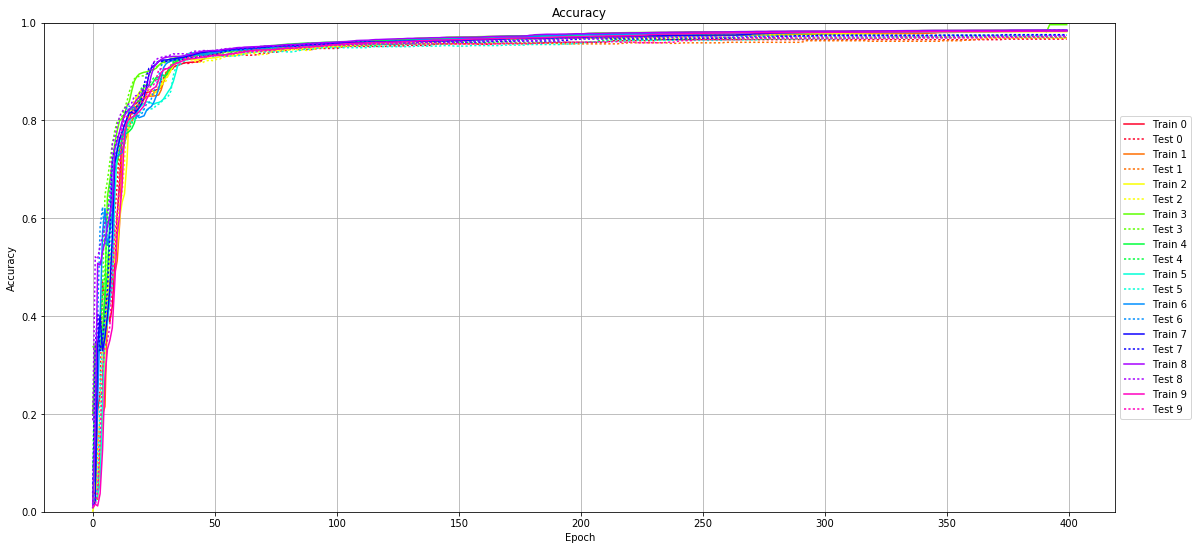

In [14]:
plot_acc(history)

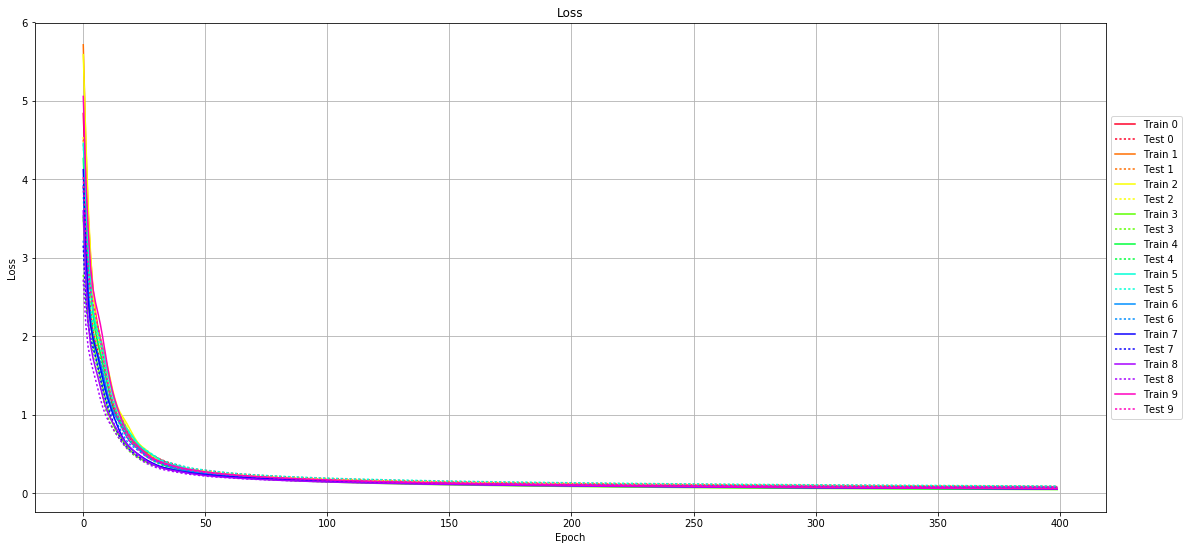

In [15]:
plot_loss(history)

In [16]:
# Viewing the confusion matrix
conf_mat = conf_mat.T  # since rows and cols are interchangeable
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix

Plotting the confusion matrix


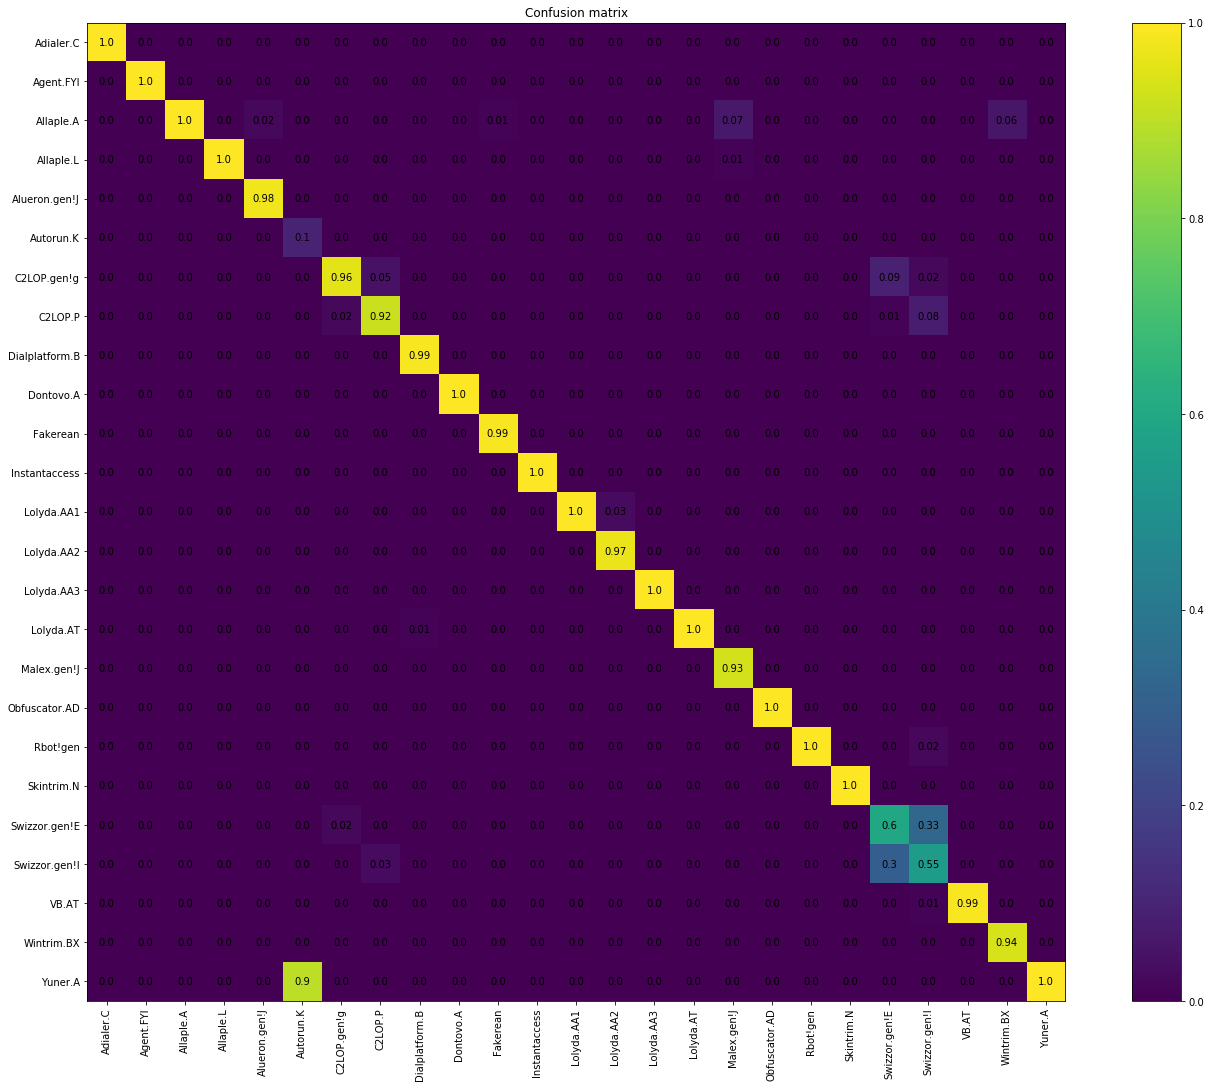

In [17]:
print("Plotting the confusion matrix")
conf_mat = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(24, 18)
plt.imshow(conf_mat,interpolation='nearest')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.title('Confusion matrix')
plt.colorbar()
plt.show()